In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import backend as K

from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping


import pylab
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt

In [ ]:
RANDOM_STATE=42

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Itog/Small.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,288
0,281.1261,5.2019,4.9755,4.8077,4.6789,4.6716,4.4699,4.4669,272.5268,4.6808,...,0.9458,0.0000,-0.6543,0.0427,0.4482,0.7899,1.0149,1.1537,1.4483,0.0
1,336.6726,5.0464,4.8182,4.7258,4.5225,4.5546,4.4657,4.5582,328.6995,4.1517,...,1.0008,0.0095,1.3937,1.3188,1.3582,1.2059,1.3286,1.4715,0.8529,0.0
2,290.2059,5.0463,4.7287,4.6207,4.5631,4.5707,4.4580,4.3681,255.7782,3.7374,...,1.5204,-0.0156,1.3963,1.3386,1.4358,1.4311,1.3677,1.6846,1.7238,0.0
3,340.9563,5.1230,4.8917,4.5914,4.6239,4.5577,4.4663,4.4310,319.4096,4.6115,...,1.7294,0.0000,-0.0617,1.1793,1.1271,1.3000,1.3077,1.5584,1.6281,0.0
4,276.8253,5.1806,4.8622,4.7099,4.5290,4.6399,4.3291,4.2316,257.5264,3.8630,...,1.6827,0.0000,0.3654,1.2722,1.4114,1.5722,1.5142,1.1071,1.5082,0.0


In [ ]:
x = df.drop(288, axis=1)
y = df[288]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Создаем модель

In [ ]:
model = Sequential(
    [
        Dense(units=512, activation="relu", input_shape=(X_train.shape[-1],) ),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(units=256, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(units=128, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(units=32, activation="relu" ),
        BatchNormalization(),
        Dropout(0.3),

        Dense(units=1, activation="sigmoid"),
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               147968    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

### Создадим EarlyStopping и ModelCheckpoint

In [ ]:
early_stopping = EarlyStopping(
    min_delta = 0.005, 
    patience  = 30,     
    restore_best_weights=True,
)

filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_f1_m',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1_m])

In [ ]:
results = model.fit(X_train, y_train, validation_data = (X_test, y_test), 
                    batch_size = 1024, epochs=300, callbacks=[early_stopping, checkpoint])

Epoch 1/300
76/79 [===========================>..] - ETA: 0s - loss: 0.6669 - f1_m: 0.2374
Epoch 1: val_f1_m improved from -inf to 0.46718, saving model to my_best_model.hdf5
79/79 [==============================] - 3s 22ms/step - loss: 0.6629 - f1_m: 0.2397 - val_loss: 0.4305 - val_f1_m: 0.4672
Epoch 2/300
76/79 [===========================>..] - ETA: 0s - loss: 0.4036 - f1_m: 0.4489
Epoch 2: val_f1_m improved from 0.46718 to 0.73623, saving model to my_best_model.hdf5
79/79 [==============================] - 2s 20ms/step - loss: 0.4010 - f1_m: 0.4520 - val_loss: 0.1861 - val_f1_m: 0.7362
Epoch 3/300
76/79 [===========================>..] - ETA: 0s - loss: 0.2263 - f1_m: 0.6729
Epoch 3: val_f1_m improved from 0.73623 to 0.78350, saving model to my_best_model.hdf5
79/79 [==============================] - 2s 20ms/step - loss: 0.2249 - f1_m: 0.6742 - val_loss: 0.1093 - val_f1_m: 0.7835
Epoch 4/300
76/79 [===========================>..] - ETA: 0s - loss: 0.1398 - f1_m: 0.7848
Epoch 4: val

In [ ]:
#Загружаем лучшую модель
model = load_model(filepath, custom_objects={"f1_m": f1_m })

In [ ]:
predict_keras = model.predict(X_test)
predict_keras = np.array(predict_keras.flatten(), dtype='float64')

625/625 [==============================] - 1s 749us/step


In [ ]:
f1_1 = f1_m(y_true=y_test,
                y_pred=predict_keras).numpy()

print(f"F1 score: {f1_1}")

F1 score: 0.981712576941288


In [ ]:
def display_f1_m():
    plt.plot(results.history['f1_m'])
    plt.plot(results.history['val_f1_m'])

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def display_loss():
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

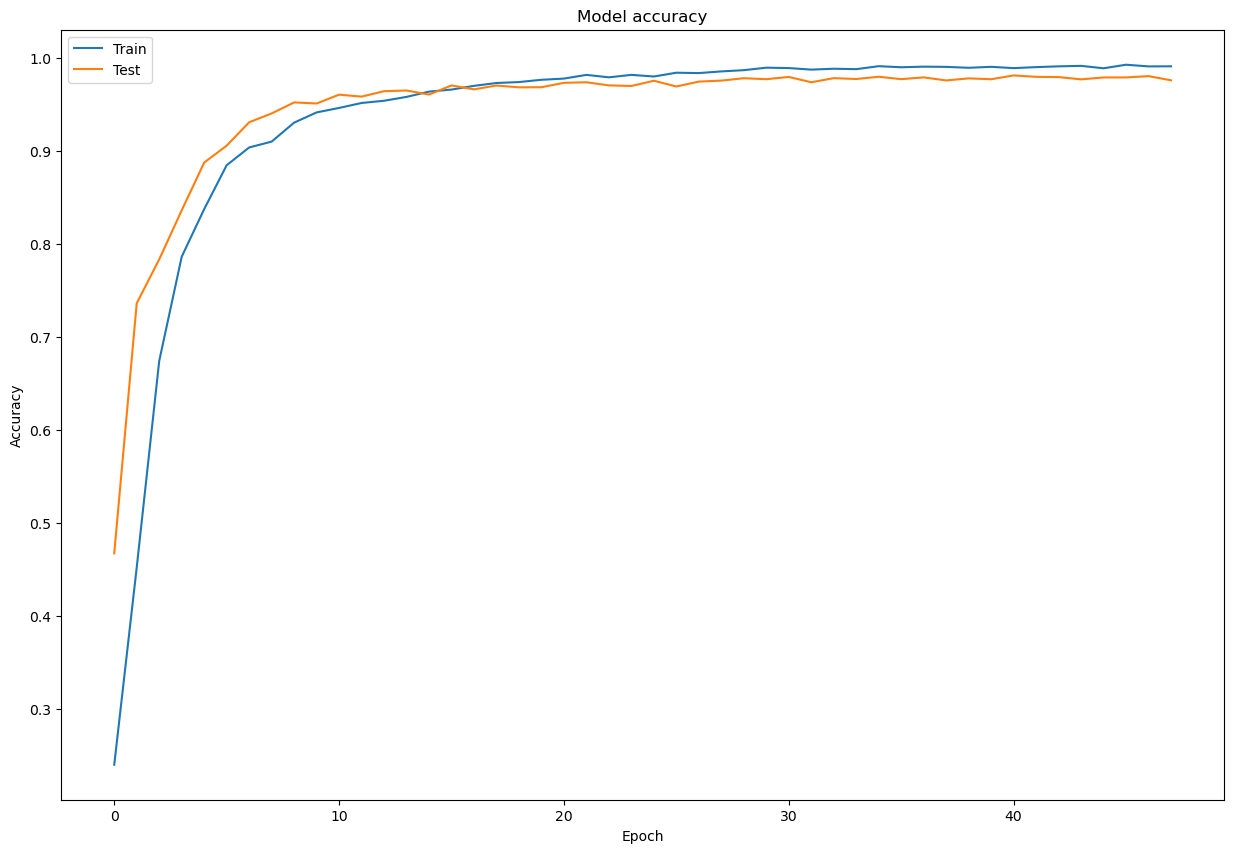

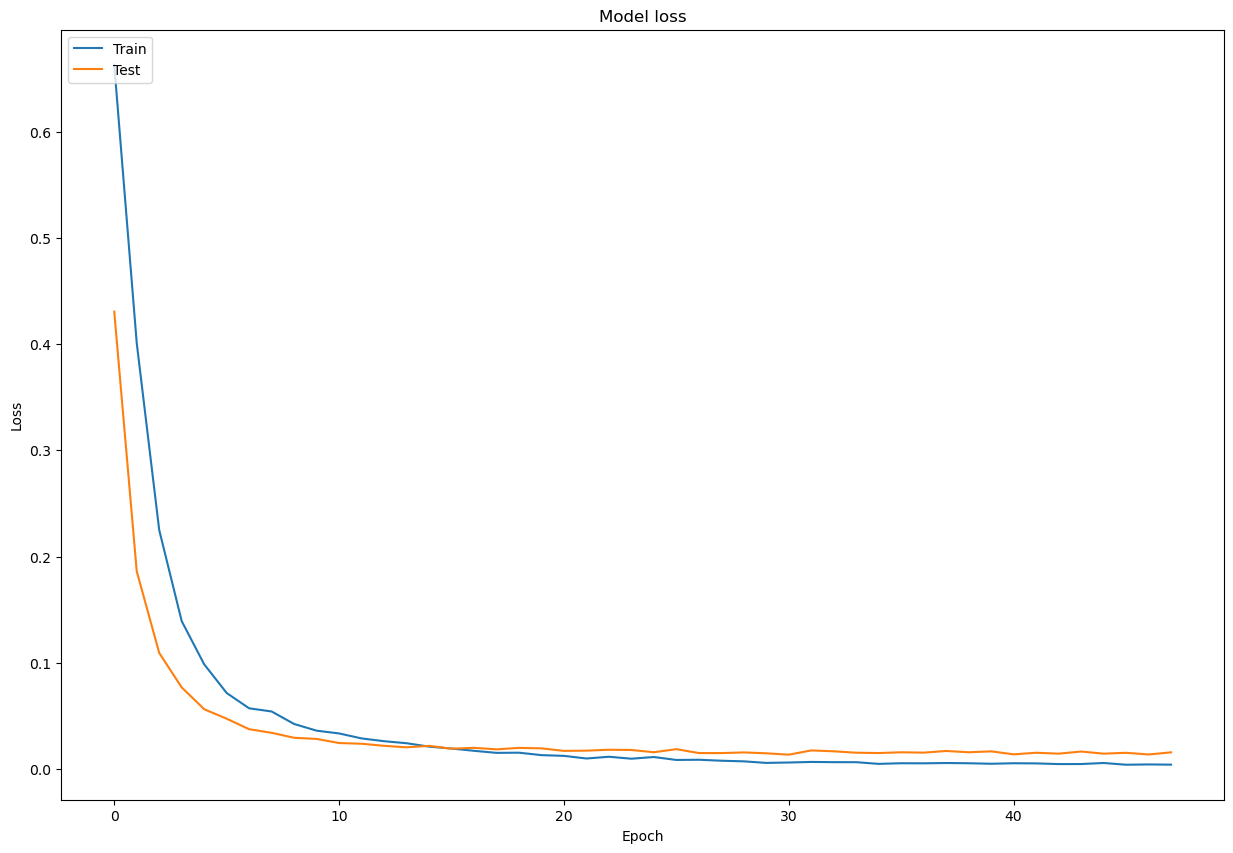

In [ ]:
display_f1_m()
display_loss()

### ML

In [ ]:
from sklearn.pipeline import Pipeline

import imblearn
from imblearn.pipeline import  Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_halving_search_cv   
from sklearn.model_selection import HalvingGridSearchCV

Используем  метод sklearn.model_selection.HalvingGridSearchCV. Он спроектирован так, чтобы быть распределенным и эффективным с более высокой скоростью привода и более высокой эффективностью, меньшим использованием памяти и большей точностью.
https://runebook.dev/ru/docs/scikit_learn/modules/generated/sklearn.model_selection.halvinggridsearchcv
https://towardsdatascience.com/faster-hyperparameter-tuning-with-scikit-learn-71aa76d06f12

Можно использовать GridSearchCV, но на него требуется больше время для обучения.


In [ ]:
from sklearn.experimental import enable_halving_search_cv   
from sklearn.model_selection import HalvingGridSearchCV


### K ближайших соседей

In [ ]:
knn_model = KNeighborsClassifier()

parameters = {
    'n_neighbors': range(1, 10)
}

grid_search_knn = HalvingGridSearchCV(knn_model, parameters, cv=3, n_jobs=-1, 
                                       scoring='f1', verbose=False)
grid_search_knn.fit(X_train, y_train)

print(f"Best score: {abs(grid_search_knn.best_score_)}, Best params: {grid_search_knn.best_params_}")

f1_2 = f1_m(y_test, K.round(grid_search_knn.predict_proba(X_test)[:,1])).numpy()
print(f"Test: {f1_2}")

Best score: 0.658302518473915, Best params: {'n_neighbors': 9}
Test: 0.7090642810321208


### Деревья решений

In [ ]:
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {
    'min_samples_split': range(2, 4),
    'min_samples_leaf': range(1, 4),
    'max_depth': range(20, 40, 5)
}

grid_search_tree = HalvingGridSearchCV(model_tree, parameters, cv=3, n_jobs=-1, 
                                       scoring='f1', verbose=False)
grid_search_tree.fit(X_train, y_train);

print(f"Best score: {abs(grid_search_tree.best_score_)}, Best params: {grid_search_tree.best_params_}")

f1_3 = f1_m(y_test, K.round(grid_search_tree.predict_proba(X_test)[:,1])).numpy()
print(f"Test: {f1_3}")

Best score: 0.7933024601594761, Best params: {'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 3}
Test: 0.8617933799941364


### Случайный лес (классификация)

In [ ]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)

parameters = {
    'min_samples_split': range(6, 9),
    'min_samples_leaf': range(9, 11),
    'max_depth': range(130, 150, 10),
    'max_features':['auto', "sqrt"],
    'n_estimators': [100, 200],
    'class_weight': [None, "balanced"]
}
grid_search_forest = HalvingGridSearchCV(model_forest, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=False)
grid_search_forest.fit(X_train, y_train)

print(f"Best score: {abs(grid_search_forest.best_score_)}, Best params: {grid_search_forest.best_params_}")

f1_4 = f1_m(y_test, K.round(grid_search_forest.predict_proba(X_test)[:,1])).numpy()
print(f"Test: {f1_4}")

Best score: 0.8382497552315754, Best params: {'class_weight': 'balanced', 'max_depth': 130, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 100}
Test: 0.9019115767750931


### Light Gradient Boosted Machine LGBMClassifier

In [ ]:
model_light = LGBMClassifier(random_state=RANDOM_STATE)

parameters = {
    'n_estimators': range(300, 500, 50),
    'max_depth': range(9, 14),
    'learning_rate': [0.5, 0.05]
}


grid_search_light = HalvingGridSearchCV(model_light, parameters, cv=3, n_jobs=-1, 
                                       scoring='f1', verbose=False)
grid_search_light.fit(X_train, y_train)

print(f"Best score: {abs(grid_search_light.best_score_)}, Best params: {grid_search_light.best_params_}")

f1_5 = f1_m(y_test, K.round(grid_search_light.predict_proba(X_test)[:,1])).numpy()
print(f"Test: {f1_5}")

Best score: 0.952911893293984, Best params: {'learning_rate': 0.5, 'max_depth': 12, 'n_estimators': 400}
Test: 0.9777517063955328


#### Теперь отбалансируем данные с помощью SMOTE


1. DecisionTreeClassifier
2. RandomForestClassifier
3. LGBMClassifier


Про SMOTE:

+  https://medium.com/nuances-of-programming/smote-метод-увеличения-числа-примеров-миноритарного-класса-da91a62f9914
+  https://imbalanced-learn.org/stable/user_guide.html#user-guide

### Light Gradient Boosted Machine LGBMClassifier SMOTE

In [ ]:
pipeline_light_smote = imbPipeline(steps=[
                            ('smote', SMOTE(random_state=RANDOM_STATE)),
                            ('light', LGBMClassifier(random_state=RANDOM_STATE))
                          ])

parameters = {
    'light__n_estimators': range(300, 500, 50),
    'light__max_depth': range(9, 14),
    'light__learning_rate': [0.1, 0.5, 0.05]
}

grid_search_light_smote = HalvingGridSearchCV(pipeline_light_smote, parameters, cv=3, n_jobs=-1, 
                                       scoring='f1', verbose=False)
grid_search_light_smote.fit(X_train, y_train)

print(f"Best score: {abs(grid_search_light_smote.best_score_)}, Best params: {grid_search_light_smote.best_params_}")

f1_6 = f1_m(y_test, K.round(grid_search_light_smote.predict_proba(X_test)[:,1])).numpy()
print(f"Test: {f1_6}")

Best score: 0.9608880581293929, Best params: {'light__learning_rate': 0.5, 'light__max_depth': 10, 'light__n_estimators': 450}
Test: 0.9772195761201705


### DecisionTreeClassifier SMOTE

In [ ]:
pipeline_tree_smote = imbPipeline(steps=[
                            ('smote', SMOTE(random_state=RANDOM_STATE)),
                            ('tree', DecisionTreeClassifier(random_state=RANDOM_STATE))
                          ])

parameters = {
    'tree__min_samples_split': range(2, 4),
    'tree__min_samples_leaf': range(1, 4),
    'tree__max_depth': range(20, 40, 5)
}

grid_search_tree_smote = HalvingGridSearchCV(pipeline_tree_smote, parameters, cv=3, n_jobs=-1, 
                                       scoring='f1', verbose=False)
grid_search_tree_smote.fit(X_train, y_train);

print(f"Best score: {abs(grid_search_tree_smote.best_score_)}, Best params: {grid_search_tree_smote.best_params_}")

f1_7 = f1_m(y_test, K.round(grid_search_tree_smote.predict_proba(X_test)[:,1])).numpy()
print(f"Test: {f1_7}")

Best score: 0.5658607041006616, Best params: {'tree__max_depth': 35, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 2}
Test: 0.6124323825925387


### RandomForestClassifier SMOTE

In [ ]:
pipeline_forest_smote = imbPipeline(steps=[
                            ('smote', SMOTE(random_state=RANDOM_STATE)),
                            ('forest', RandomForestClassifier(random_state=RANDOM_STATE))
                          ])


parameters = {
    'forest__min_samples_split': range(6, 9),
    'forest__min_samples_leaf': range(9, 11),
    'forest__max_depth': range(130, 150, 10),
    'forest__max_features':['auto', "sqrt"],
    'forest__n_estimators': [100, 200],
    'forest__class_weight': [None, "balanced"]
}

grid_search_forest_smote = HalvingGridSearchCV(pipeline_forest_smote, parameters, cv=3, n_jobs=-1, 
                                       scoring='f1', verbose=False)
grid_search_forest_smote.fit(X_train, y_train)

print(f"Best score: {abs(grid_search_forest_smote.best_score_)}, Best params: {grid_search_forest_smote.best_params_}")

f1_8 = f1_m(y_test, K.round(grid_search_forest_smote.predict_proba(X_test)[:,1])).numpy()
print(f"Test: {f1_8}")

Best score: 0.8817099059912076, Best params: {'forest__class_weight': None, 'forest__max_depth': 130, 'forest__max_features': 'sqrt', 'forest__min_samples_leaf': 9, 'forest__min_samples_split': 6, 'forest__n_estimators': 200}
Test: 0.9289417006466919


### Тестируем лучшие модельки

In [ ]:
# f1_test_light_smote = f1_score(grid_search_light_smote.predict(X_test), y_test)
# print(f"LGBMClassifier + SMOTE, f1: {f1_test_light_smote}")

In [ ]:
# f1_test_forest_smote = f1_score(grid_search_forest_smote.predict(X_test), y_test)
# print(f"RandomForestClassifier + SMOTE, f1: {f1_test_forest_smote}")

In [ ]:
# f1_1 = f1_keras.numpy()
# f1_2 = f1_test_light_smote
# f1_3 = f1_test_forest_smote

**Итоговая оценка**

In [ ]:
print(f"""
        Keras: {f1_1}, \n
        KNeighbors: {f1_2}, \n
        DecisionTree: {f1_3},  \n
        RandomForest: {f1_4}, \n
        LGBM: {f1_5}, \n
        LGBM:  + SMOTE: {f1_6}, \n
        DecisionTree + SMOTE: {f1_7}, \n
        RandomForest + SMOTE: {f1_8}
        """) 

print("Средняя f1 мера составляет", (f1_1 + f1_5 + f1_8)/3)
print("Количество баллов равно", max(min(22, (f1_1*100 + f1_5*100 + f1_8*100)/3-75),0))


        Keras: 0.981712576941288, 

        KNeighbors: 0.7090642810321208, 

        DecisionTree: 0.8617933799941364,  

        RandomForest: 0.9019115767750931, 

        LGBM: 0.9777517063955328, 

        LGBM:  + SMOTE: 0.9772195761201705, 

        DecisionTree + SMOTE: 0.6124323825925387, 

        RandomForest + SMOTE: 0.9289417006466919
        
Средняя f1 мера составляет 0.9628019946611709
Количество баллов равно 21.280199466117097
